In [219]:
import warnings
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import simdjson
from pydantic import BaseModel
from rich import print

warnings.filterwarnings("ignore")

from xdf_types import XDFData

# Set style for better-looking plots
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (16, 9)  # 16:9 aspect ratio for presentations

In [220]:
class AnswerRound(BaseModel):
    round_number: int
    latency_applied: int  # Actual latency in milliseconds from LatencyMarkers stream
    blocks_moved: int  # Number of blocks moved during this round (from BoxBlockMarkers)
    delays_experienced: int  # Answer to "Did you experience delays..."
    task_difficulty: int  # Answer to "How difficult was it..."
    felt_controlling: int  # Answer to "I felt like I was controlling..."
    felt_part_of_body: int  # Answer to "It felt like the robot was part of my body"


class Participant(BaseModel):
    submission_id: int
    created: str
    participant_number: int
    gender: str
    age: int
    dominant_hand: str  # Can be "Right hand", "Left hand", "Ambidextrous", etc.
    robotics_experience: int
    answer_time_ms: float
    rounds: list[AnswerRound]


# 4: Has 3 different XDF files
# 33: Doesn't have ExpMarkers
ignored_participants = [4, 33]

In [221]:
questionnaire_df = pd.read_csv(
    "data/questionnaire_data-561422-2025-11-21-1620.csv", sep=";"
)

In [222]:
# Static columns (demographics)
static_cols = [
    "$submission_id",
    "$created",
    "Participant number",
    "What is your gender",
    "How old are you?",
    "What is your dominant hand?",
    "How experienced are you with robotic systems?",
    "$answer_time_ms",
]

# The repeating question columns
repeating_questions = [
    "Did you experience delays between your actions and the robot&#39;s movements?",
    "How difficult was it to perform the task?",
    "I felt like I was controlling the movement of the robot",
    "It felt like the robot was part of my body",
]

# Count how many rounds we have
all_cols = questionnaire_df.columns.tolist()
# Remove static columns to get only repeating ones
repeating_cols = [col for col in all_cols if col not in static_cols]
num_rounds = len(repeating_cols) // len(repeating_questions)

print(f"Number of rounds: {num_rounds}")

Number of rounds: 10

In [223]:
participants: list[Participant] = []

for _, row in questionnaire_df.iterrows():
    participant_number = int(row["Participant number"])
    if participant_number in ignored_participants:
        continue

    data_file = f"./data/sub-{participant_number:03d}/sub-{participant_number:03d}_ses-_task-_run-001.json"
    json_parser = simdjson.Parser()
    data: XDFData = cast(XDFData, json_parser.load(data_file))

    # Extract latency markers from the data
    latency_markers_stream = next(
        (
            stream
            for stream in data["streams"]
            if stream["info"]["name"] == "LatencyMarkers"
        ),
        None,
    )

    if latency_markers_stream is None:
        raise ValueError(
            f"LatencyMarkers stream not found for participant {participant_number}"
        )

    # Extract latencies from condition_advance markers
    # Format: ["condition_advance|rep_1|200ms|condition_1"]
    latencies_by_round = []
    for marker in latency_markers_stream["time_series"]:
        marker_str = marker[0]
        if marker_str.startswith("condition_advance|"):
            parts = marker_str.split("|")
            if len(parts) >= 3:
                latency_str = parts[2]  # e.g., "200ms"
                latency_ms = int(latency_str.replace("ms", ""))
                latencies_by_round.append(latency_ms)

    # Extract ExpMarkers stream to count block_moved events
    # Note: Some participants have duplicate ExpMarkers streams (identical events)
    # We only need to process one of them
    exp_markers_stream = None
    for stream in data["streams"]:
        if stream["info"]["name"] == "ExpMarkers":
            exp_markers_stream = stream
            break

    if exp_markers_stream is None:
        raise ValueError(
            f"No ExpMarkers stream found for participant {participant_number}"
        )

    # Count blocks moved per round
    blocks_moved_by_round = []
    current_round_blocks = 0
    in_boxblock = False

    for i, marker in enumerate(exp_markers_stream["time_series"]):
        marker_str = marker[0]

        # Handle both practice and regular boxblock sessions
        if marker_str in ["boxblock_start", "practice_boxblock_start"]:
            # If we were already in a session, save the count first
            if in_boxblock and marker_str == "boxblock_start":
                blocks_moved_by_round.append(current_round_blocks)
            in_boxblock = True
            current_round_blocks = 0
        elif marker_str in [
            "boxblock_stop",
            "practice_boxblock_stop",
            "boxblock_end",
        ]:
            if in_boxblock:
                blocks_moved_by_round.append(current_round_blocks)
                in_boxblock = False
                current_round_blocks = 0
        elif marker_str == "block_moved" and in_boxblock:
            current_round_blocks += 1

    # Ensure we have the right number of block counts
    while len(blocks_moved_by_round) < num_rounds:
        blocks_moved_by_round.append(0)

    # Parse answer rounds
    rounds = []
    for round_idx in range(num_rounds):
        # Column names have suffixes like .1, .2, etc. (pandas duplicate column naming)
        # First occurrence has no suffix, then .1, .2, .3, etc.
        suffix = f".{round_idx}" if round_idx > 0 else ""

        round_data = AnswerRound(
            round_number=round_idx + 1,
            latency_applied=latencies_by_round[round_idx]
            if round_idx < len(latencies_by_round)
            else 0,
            blocks_moved=blocks_moved_by_round[round_idx]
            if round_idx < len(blocks_moved_by_round)
            else 0,
            delays_experienced=int(row[f"{repeating_questions[0]}{suffix}"]),
            task_difficulty=int(row[f"{repeating_questions[1]}{suffix}"]),
            felt_controlling=int(row[f"{repeating_questions[2]}{suffix}"]),
            felt_part_of_body=int(row[f"{repeating_questions[3]}{suffix}"]),
        )
        rounds.append(round_data)

    # Create participant with all rounds
    participant = Participant(
        submission_id=int(row["$submission_id"]),
        created=str(row["$created"]),
        participant_number=participant_number,
        gender=str(row["What is your gender"]),
        age=int(row["How old are you?"]),
        dominant_hand=str(row["What is your dominant hand?"]),
        robotics_experience=int(row["How experienced are you with robotic systems?"]),
        answer_time_ms=float(row["$answer_time_ms"]),
        rounds=rounds,
    )
    participants.append(participant)

In [224]:
print(f"Total participants: {len(participants)}")
print(f"Total rounds per participant: {num_rounds}")

Total participants: 38

Total rounds per participant: 10

In [225]:
data_rows = []
for participant in participants:
    for round_data in participant.rounds:
        data_rows.append(
            {
                "participant_number": participant.participant_number,
                "round_number": round_data.round_number,
                "latency_applied": round_data.latency_applied,
                "delays_experienced": round_data.delays_experienced,
                "task_difficulty": round_data.task_difficulty,
                "felt_controlling": round_data.felt_controlling,
                "felt_part_of_body": round_data.felt_part_of_body,
                "blocks_moved": round_data.blocks_moved,
                "age": participant.age,
                "gender": participant.gender,
                "robotics_experience": participant.robotics_experience,
            }
        )

df_long = pd.DataFrame(data_rows)

print("Data structure:")
print(df_long.head(10))
print(f"Shape: {df_long.shape}")
print(f"Unique latency conditions: {sorted(df_long['latency_applied'].unique())}")

Data structure:

participant_number  round_number  latency_applied  delays_experienced  \
0                   1             1              200                   2   
1                   1             2               50                   2   
2                   1             3              150                   2   
3                   1             4              100                   2   
4                   1             5                0                   2   
5                   1             6              150                   3   
6                   1             7              200                   3   
7                   1             8               50                   2   
8                   1             9              100                   2   
9                   1            10                0                   3   

   task_difficulty  felt_controlling  felt_part_of_body  blocks_moved  age  \
0                2                 4                  1             0   24   
1                1                 4                  1             1   24   
2                2                 4                  1             4   24   
3                2                 4                  1             4   24   
4                4                 3                  1             0   24   
5                3                 3                  1             4   24   
6                3                 3                  1             6   24   
7                2                 3                  1             4   24   
8                3                 2                  1             4   24   
9                3                 3                  1             6   24   

  gender  robotics_experience  
0   Male                    1  
1   Male                    1  
2   Male                    1  
3   Male                    1  
4   Male                    1  
5   Male                    1  
6   Male                    1  
7   Male                    1  
8   Male                    1  
9   Male                    1

Shape: (380, 11)

Unique latency conditions:

In [226]:
dependent_vars = {
    "delays_experienced": "Delays Experienced (1-7)",
    "task_difficulty": "Task Difficulty (1-7)",
    "felt_controlling": "Felt Controlling Robot (1-7)",
    "felt_part_of_body": "Robot Felt Part of Body (1-7)",
    "blocks_moved": "Number of blocks moved",
}

In [227]:
anova_results = {}

for dv_name, dv_label in dependent_vars.items():
    print(f"\n{'─' * 80}")
    print(f"Analysis: {dv_label}")
    print(f"Independent Variable: Latency Applied (ms)")
    print(f"{'─' * 80}")

    # Run repeated measures ANOVA
    aov = pg.rm_anova(
        data=df_long,
        dv=dv_name,
        within="latency_applied",
        subject="participant_number",
        detailed=True,
    )

    # Extract variance components
    ss_treatment = aov.loc[aov["Source"] == "latency_applied", "SS"].values[0]
    ss_error = aov.loc[aov["Source"] == "Error", "SS"].values[0]
    df_treatment = aov.loc[aov["Source"] == "latency_applied", "DF"].values[0]
    df_error = aov.loc[aov["Source"] == "Error", "DF"].values[0]
    f_value = aov.loc[aov["Source"] == "latency_applied", "F"].values[0]
    p_value = aov.loc[aov["Source"] == "latency_applied", "p-unc"].values[0]

    # Store results
    anova_results[dv_name] = {
        "table": aov,
        "SSA": ss_treatment,
        "SSE": ss_error,
        "F": f_value,
        "p": p_value,
        "significant": p_value < 0.05,
    }

    # Print ANOVA table
    print("\nANOVA Table:")
    print(aov.to_string(index=False))

    # Print variance components (as required)
    print(f"\nVariance Components:")
    print(f"  SSA (Sum of Squares - Treatment): {ss_treatment:.4f}")
    print(f"  SSE (Sum of Squares - Error):     {ss_error:.4f}")
    print(f"  Total SS:                         {ss_treatment + ss_error:.4f}")
    print(f"  F-statistic:                      {f_value:.4f}")
    print(f"  p-value:                          {p_value:.6f}")

    if p_value < 0.05:
        print(f"  Result: SIGNIFICANT (p < 0.05) ✓")
    else:
        print(f"  Result: NOT SIGNIFICANT (p ≥ 0.05)")

────────────────────────────────────────────────────────────────────────────────

Analysis: Delays Experienced (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS         F        p-unc      ng2      eps
latency_applied 19.698799   4 4.924700 10.954844 8.773294e-08 0.123722 0.907088
          Error 64.734535 144 0.449545       NaN          NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 19.6988

SSE (Sum of Squares - Error):     64.7345

Total SS:                         84.4333

F-statistic:                      10.9548

p-value:                          0.000000

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Task Difficulty (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  7.770871   4 1.942718 5.944257 0.000187 0.079384 0.869817
          Error 47.062462 144 0.326823      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 7.7709

SSE (Sum of Squares - Error):     47.0625

Total SS:                         54.8333

F-statistic:                      5.9443

p-value:                          0.000187

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Felt Controlling Robot (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  2.925826   4 0.731456 2.480502 0.046539 0.029871 0.881729
          Error 42.463063 144 0.294882      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 2.9258

SSE (Sum of Squares - Error):     42.4631

Total SS:                         45.3889

F-statistic:                      2.4805

p-value:                          0.046539

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Robot Felt Part of Body (1-7)

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source        SS  DF       MS        F    p-unc      ng2      eps
latency_applied  6.650150   4 1.662538 5.774237 0.000244 0.036117 0.887826
          Error 41.460961 144 0.287923      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 6.6502

SSE (Sum of Squares - Error):     41.4610

Total SS:                         48.1111

F-statistic:                      5.7742

p-value:                          0.000244

Result: SIGNIFICANT (p < 0.05) ✓

────────────────────────────────────────────────────────────────────────────────

Analysis: Number of blocks moved

Independent Variable: Latency Applied (ms)

────────────────────────────────────────────────────────────────────────────────

ANOVA Table:

Source         SS  DF       MS        F    p-unc      ng2      eps
latency_applied  20.527628   4 5.131907 2.249564 0.066612 0.038837 0.819691
          Error 328.505706 144 2.281290      NaN      NaN      NaN      NaN

Variance Components:

SSA (Sum of Squares - Treatment): 20.5276

SSE (Sum of Squares - Error):     328.5057

Total SS:                         349.0333

F-statistic:                      2.2496

p-value:                          0.066612

Result: NOT SIGNIFICANT (p ≥ 0.05)

In [228]:
posthoc_results = {}

for dv_name, dv_label in dependent_vars.items():
    if anova_results[dv_name]["significant"]:
        print(f"\n{'─' * 80}")
        print(f"Post-hoc for: {dv_label}")
        print(f"{'─' * 80}")

        # Pairwise comparisons with Bonferroni correction
        posthoc = pg.pairwise_tests(
            data=df_long,
            dv=dv_name,
            within="latency_applied",
            subject="participant_number",
            padjust="bonf",
            effsize="hedges",
        )

        posthoc_results[dv_name] = posthoc

        # Display results
        print("\nPairwise Comparisons (Bonferroni corrected):")
        print(
            posthoc[["A", "B", "T", "p-unc", "p-corr", "hedges"]].to_string(index=False)
        )

        # Highlight significant comparisons
        sig_comparisons = posthoc[posthoc["p-corr"] < 0.05]
        if len(sig_comparisons) > 0:
            print(f"\nSignificant pairwise differences (p < 0.05):")
            for _, row in sig_comparisons.iterrows():
                print(
                    f"  {row['A']}ms vs {row['B']}ms: p = {row['p-corr']:.6f}, Hedges' g = {row['hedges']:.3f}"
                )
        else:
            print("\nNo significant pairwise differences after correction.")
    else:
        print(f"\nSkipping post-hoc for '{dv_label}' (ANOVA was not significant)")

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Delays Experienced (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B         T        p-unc   p-corr    hedges
  0  50  0.558207 5.801585e-01 1.000000  0.107670
  0 100 -2.236933 3.157543e-02 0.315754 -0.457512
  0 150 -2.653546 1.177972e-02 0.117797 -0.514481
  0 200 -4.834794 2.486451e-05 0.000249 -0.891956
 50 100 -3.323717 2.049359e-03 0.020494 -0.548170
 50 150 -3.326430 2.034205e-03 0.020342 -0.605454
 50 200 -6.144749 4.453936e-07 0.000004 -0.969412
100 150 -0.276237 7.839454e-01 1.000000 -0.045200
100 200 -2.477471 1.806051e-02 0.180605 -0.441946
150 200 -3.010759 4.741552e-03 0.047416 -0.405871

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.000249, Hedges' g = -0.892

50ms vs 100ms: p = 0.020494, Hedges' g = -0.548

50ms vs 150ms: p = 0.020342, Hedges' g = -0.605

50ms vs 200ms: p = 0.000004, Hedges' g = -0.969

150ms vs 200ms: p = 0.047416, Hedges' g = -0.406

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Task Difficulty (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B         T    p-unc   p-corr    hedges
  0  50 -0.146478 0.884362 1.000000 -0.024618
  0 100 -1.740801 0.090260 0.902605 -0.331285
  0 150 -2.499015 0.017154 0.171543 -0.500103
  0 200 -4.572644 0.000055 0.000550 -0.787724
 50 100 -1.452997 0.154886 1.000000 -0.300213
 50 150 -2.949235 0.005567 0.055674 -0.461020
 50 200 -4.251034 0.000144 0.001440 -0.741585
100 150 -0.641989 0.524948 1.000000 -0.131372
100 200 -2.354891 0.024099 0.240994 -0.408896
150 200 -1.502925 0.141581 1.000000 -0.306292

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.000550, Hedges' g = -0.788

50ms vs 200ms: p = 0.001440, Hedges' g = -0.742

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Felt Controlling Robot (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B        T    p-unc   p-corr   hedges
  0  50 0.782760 0.438887 1.000000 0.129945
  0 100 1.181007 0.245344 1.000000 0.220148
  0 150 1.890617 0.066746 0.667457 0.316891
  0 200 3.275324 0.002339 0.023385 0.494058
 50 100 0.494872 0.623698 1.000000 0.074793
 50 150 0.911725 0.367978 1.000000 0.165514
 50 200 2.060320 0.046652 0.466515 0.347669
100 150 0.487563 0.628815 1.000000 0.096723
100 200 1.562404 0.126942 1.000000 0.293104
150 200 1.275586 0.210272 1.000000 0.203990

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.023385, Hedges' g = 0.494

────────────────────────────────────────────────────────────────────────────────

Post-hoc for: Robot Felt Part of Body (1-7)

────────────────────────────────────────────────────────────────────────────────

Pairwise Comparisons (Bonferroni corrected):

A   B        T    p-unc   p-corr   hedges
  0  50 0.987098 0.330183 1.000000 0.111131
  0 100 2.205797 0.033867 0.338674 0.321509
  0 150 2.563494 0.014685 0.146847 0.374128
  0 200 3.911065 0.000391 0.003905 0.537066
 50 100 1.690856 0.099506 0.995059 0.192792
 50 150 2.216907 0.033033 0.330331 0.254344
 50 200 3.439729 0.001489 0.014888 0.406641
100 150 0.733930 0.467745 1.000000 0.081759
100 200 1.884371 0.067609 0.676095 0.240081
150 200 1.263635 0.214483 1.000000 0.142918

Significant pairwise differences (p < 0.05):

0ms vs 200ms: p = 0.003905, Hedges' g = 0.537

50ms vs 200ms: p = 0.014888, Hedges' g = 0.407

Skipping post-hoc for 'Number of blocks moved' (ANOVA was not significant)

In [229]:
for dv_name, dv_label in dependent_vars.items():
    print(f"\n{dv_label}:")
    desc_stats = (
        df_long.groupby("latency_applied")[dv_name]
        .agg(
            [
                ("Mean", "mean"),
                ("SD", "std"),
                ("SE", lambda x: x.std() / np.sqrt(len(x))),
                ("Min", "min"),
                ("Max", "max"),
                ("N", "count"),
            ]
        )
        .round(3)
    )
    print(desc_stats.to_string())

Delays Experienced (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                1.989  1.000  0.107    1    5  88
50               2.027  0.912  0.107    1    4  73
100              2.514  1.075  0.127    1    5  72
150              2.527  1.149  0.134    1    5  74
200              2.890  1.149  0.135    1    5  73

Task Difficulty (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                2.068  1.003  0.107    1    4  88
50               2.260  0.986  0.115    1    5  73
100              2.500  0.964  0.114    1    4  72
150              2.568  0.861  0.100    1    4  74
200              2.781  0.917  0.107    1    4  73

Felt Controlling Robot (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                3.716  1.241  0.132    1    5  88
50               3.973  1.027  0.120    1    5  73
100              3.917  0.868  0.102    1    5  72
150              3.865  0.956  0.111    1    5  74
200              3.699  1.037  0.121    2    5  73

Robot Felt Part of Body (1-7):

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                2.773  1.239  0.132    1    5  88
50               2.904  1.132  0.133    1    5  73
100              2.750  1.045  0.123    1    5  72
150              2.662  1.174  0.136    1    5  74
200              2.534  1.081  0.127    1    5  73

Number of blocks moved:

Mean     SD     SE  Min  Max   N
latency_applied                                   
0                1.739  2.361  0.252    0   10  88
50               2.507  2.907  0.340    0   12  73
100              2.000  2.467  0.291    0   10  72
150              2.203  2.358  0.274    0   11  74
200              1.507  2.135  0.250    0    6  73

✓ Saved box plots to 'plots/anova_boxplots.png'

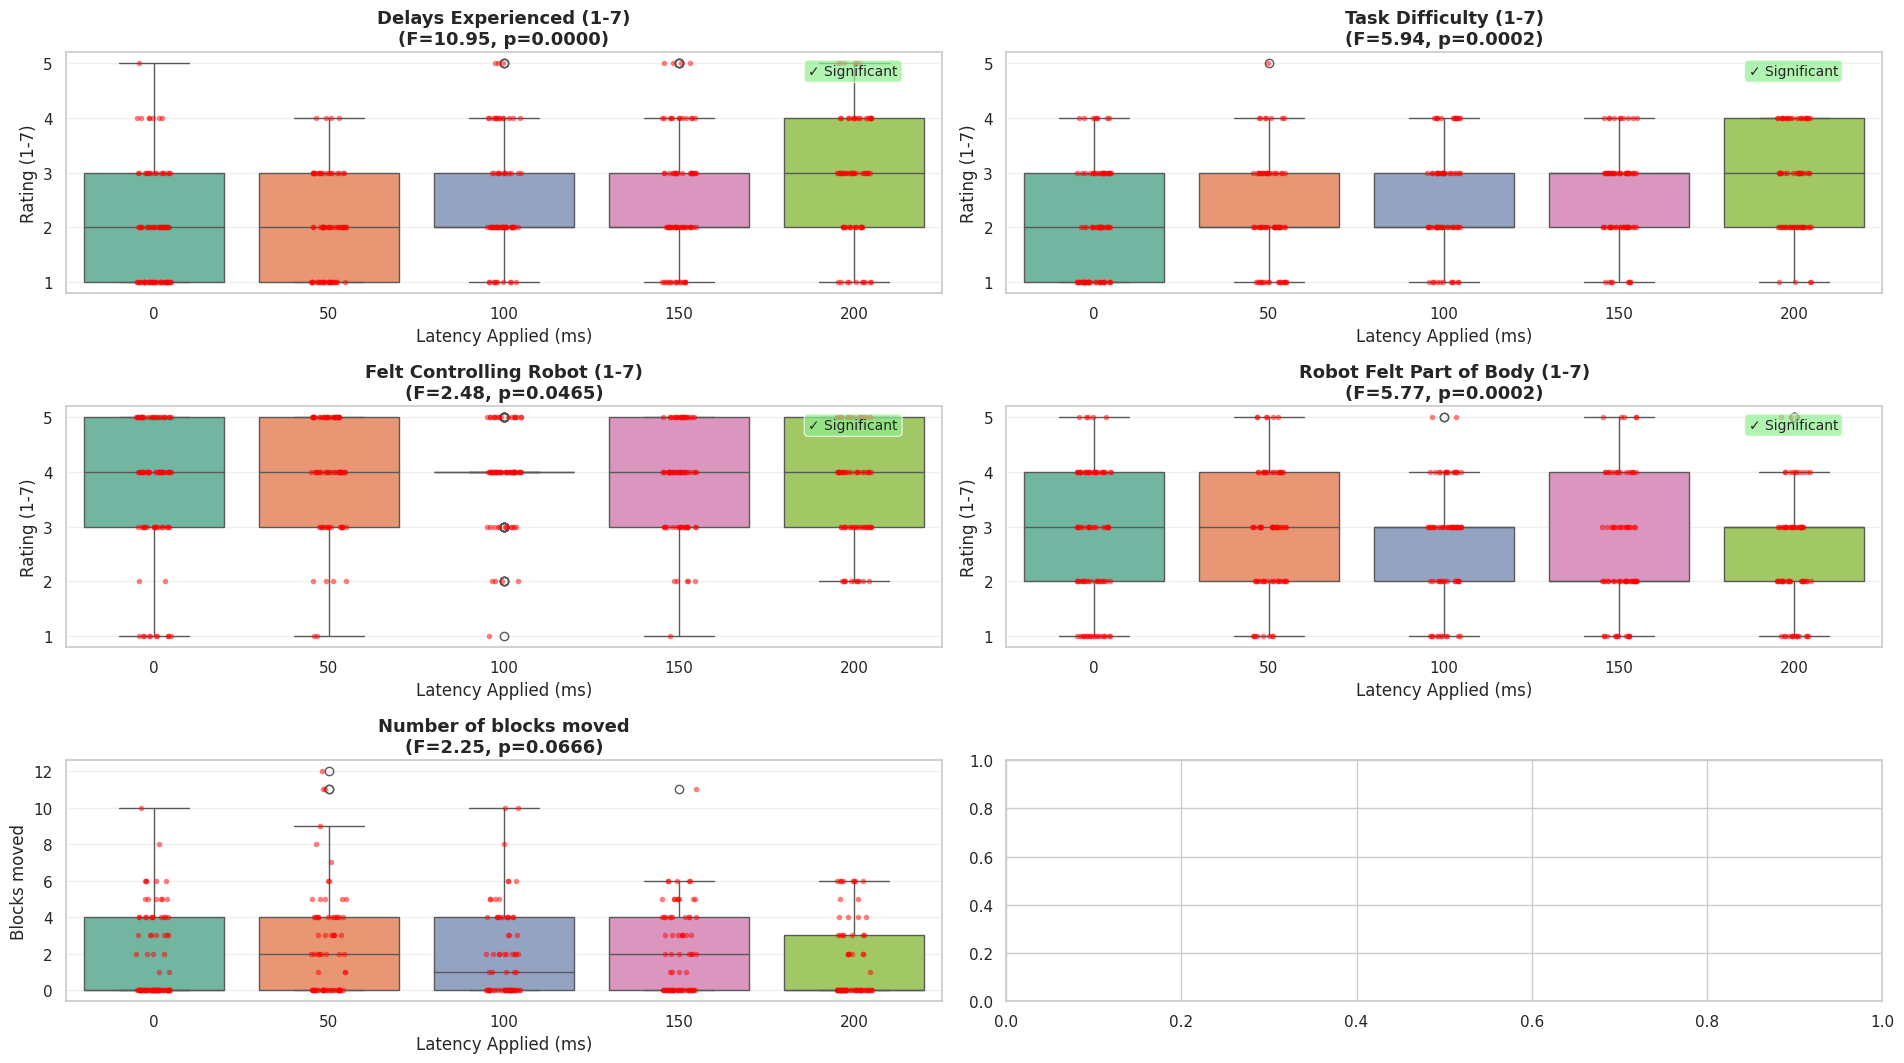

In [230]:
fig, axes = plt.subplots(3, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create box plot
    sns.boxplot(data=df_long, x="latency_applied", y=dv_name, ax=ax, palette="Set2")

    # Add individual points with jitter
    sns.stripplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        color="red",
        alpha=0.5,
        size=4,
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ylabel = "Rating (1-7)"
    if "blocks" in dv_name:
        ylabel = "Blocks moved"
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(
        f"{dv_label}\n(F={anova_results[dv_name]['F']:.2f}, p={anova_results[dv_name]['p']:.4f})",
        fontsize=13,
        fontweight="bold",
    )


    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/anova_boxplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved box plots to 'plots/anova_boxplots.png'")
plt.show()

✓ Saved point plots to 'plots/anova_pointplots.png'

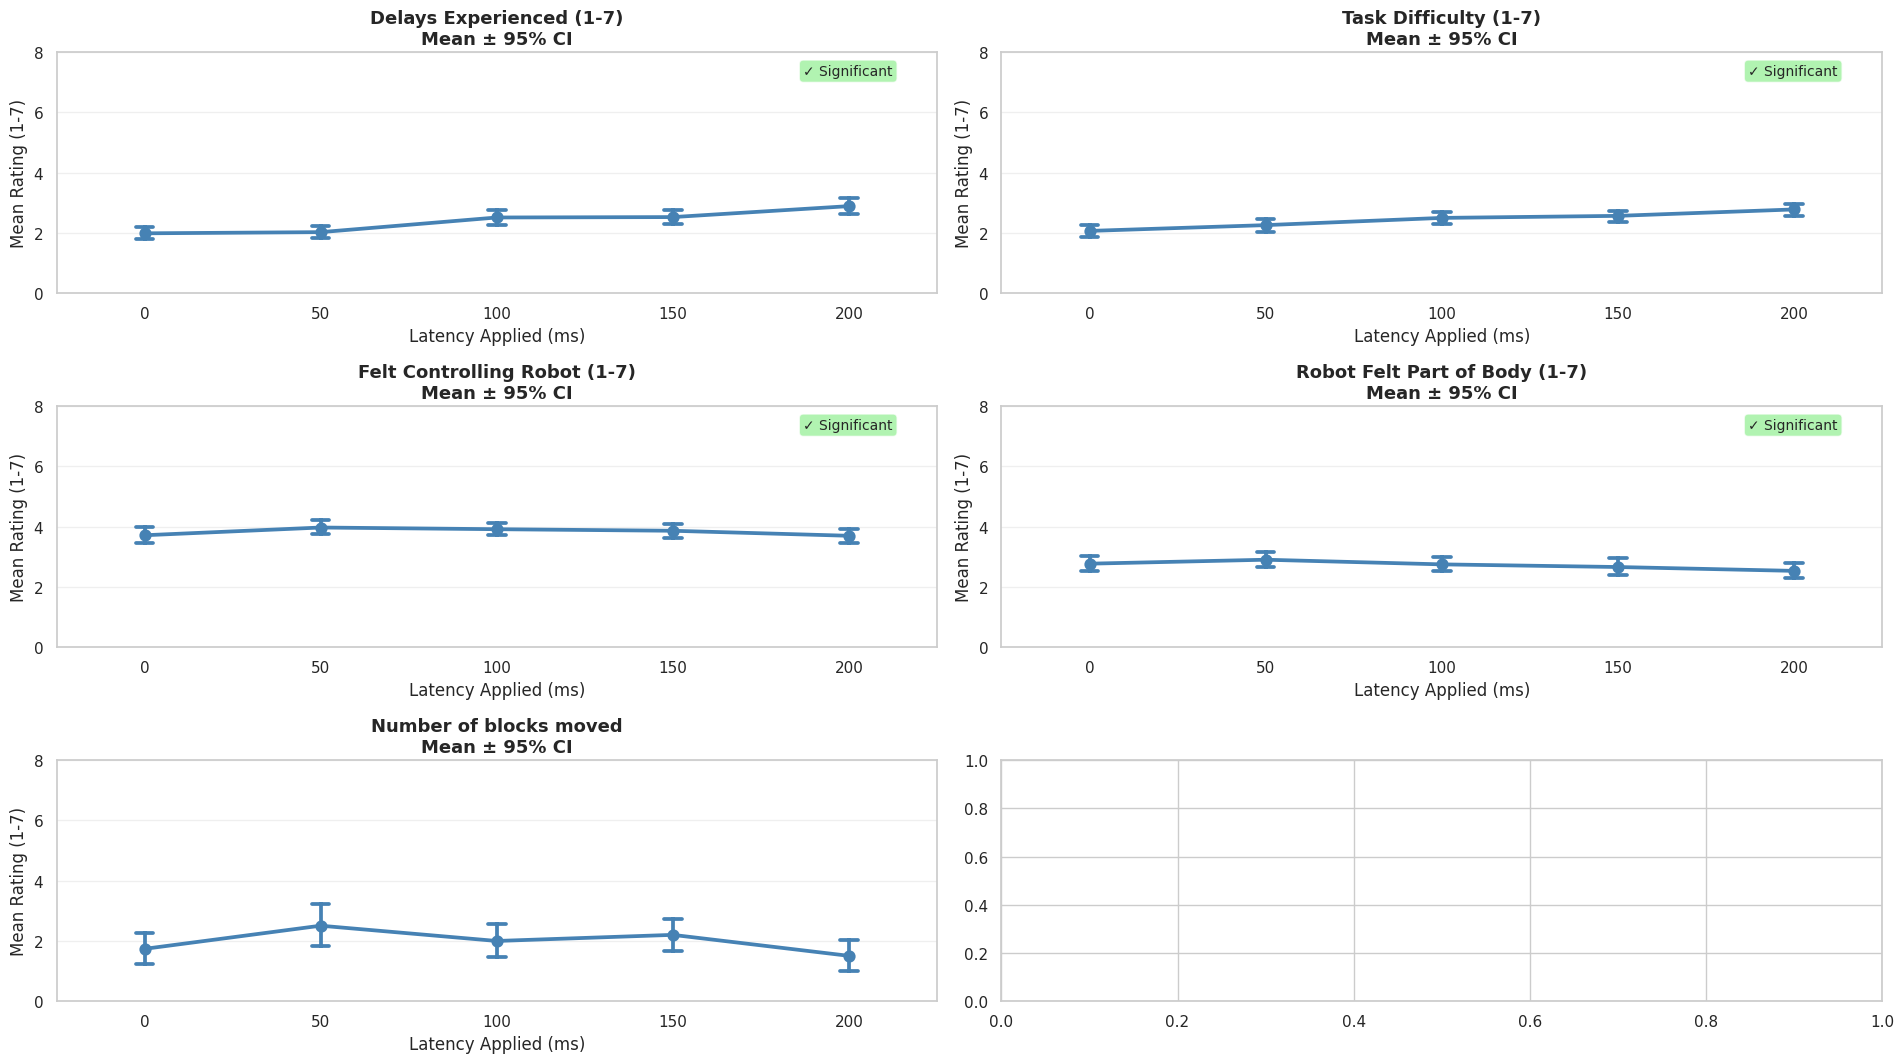

In [231]:
fig, axes = plt.subplots(3, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create point plot with 95% CI
    sns.pointplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        errorbar="ci",
        capsize=0.1,
        color="steelblue",
        markers="o",
        linestyles="-",
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ax.set_ylabel("Mean Rating (1-7)", fontsize=12)
    ax.set_title(f"{dv_label}\nMean ± 95% CI", fontsize=13, fontweight="bold")

    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 8)

plt.tight_layout()
plt.savefig("plots/anova_pointplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved point plots to 'plots/anova_pointplots.png'")
plt.show()

✓ Saved violin plots to 'plots/anova_violinplots.png'

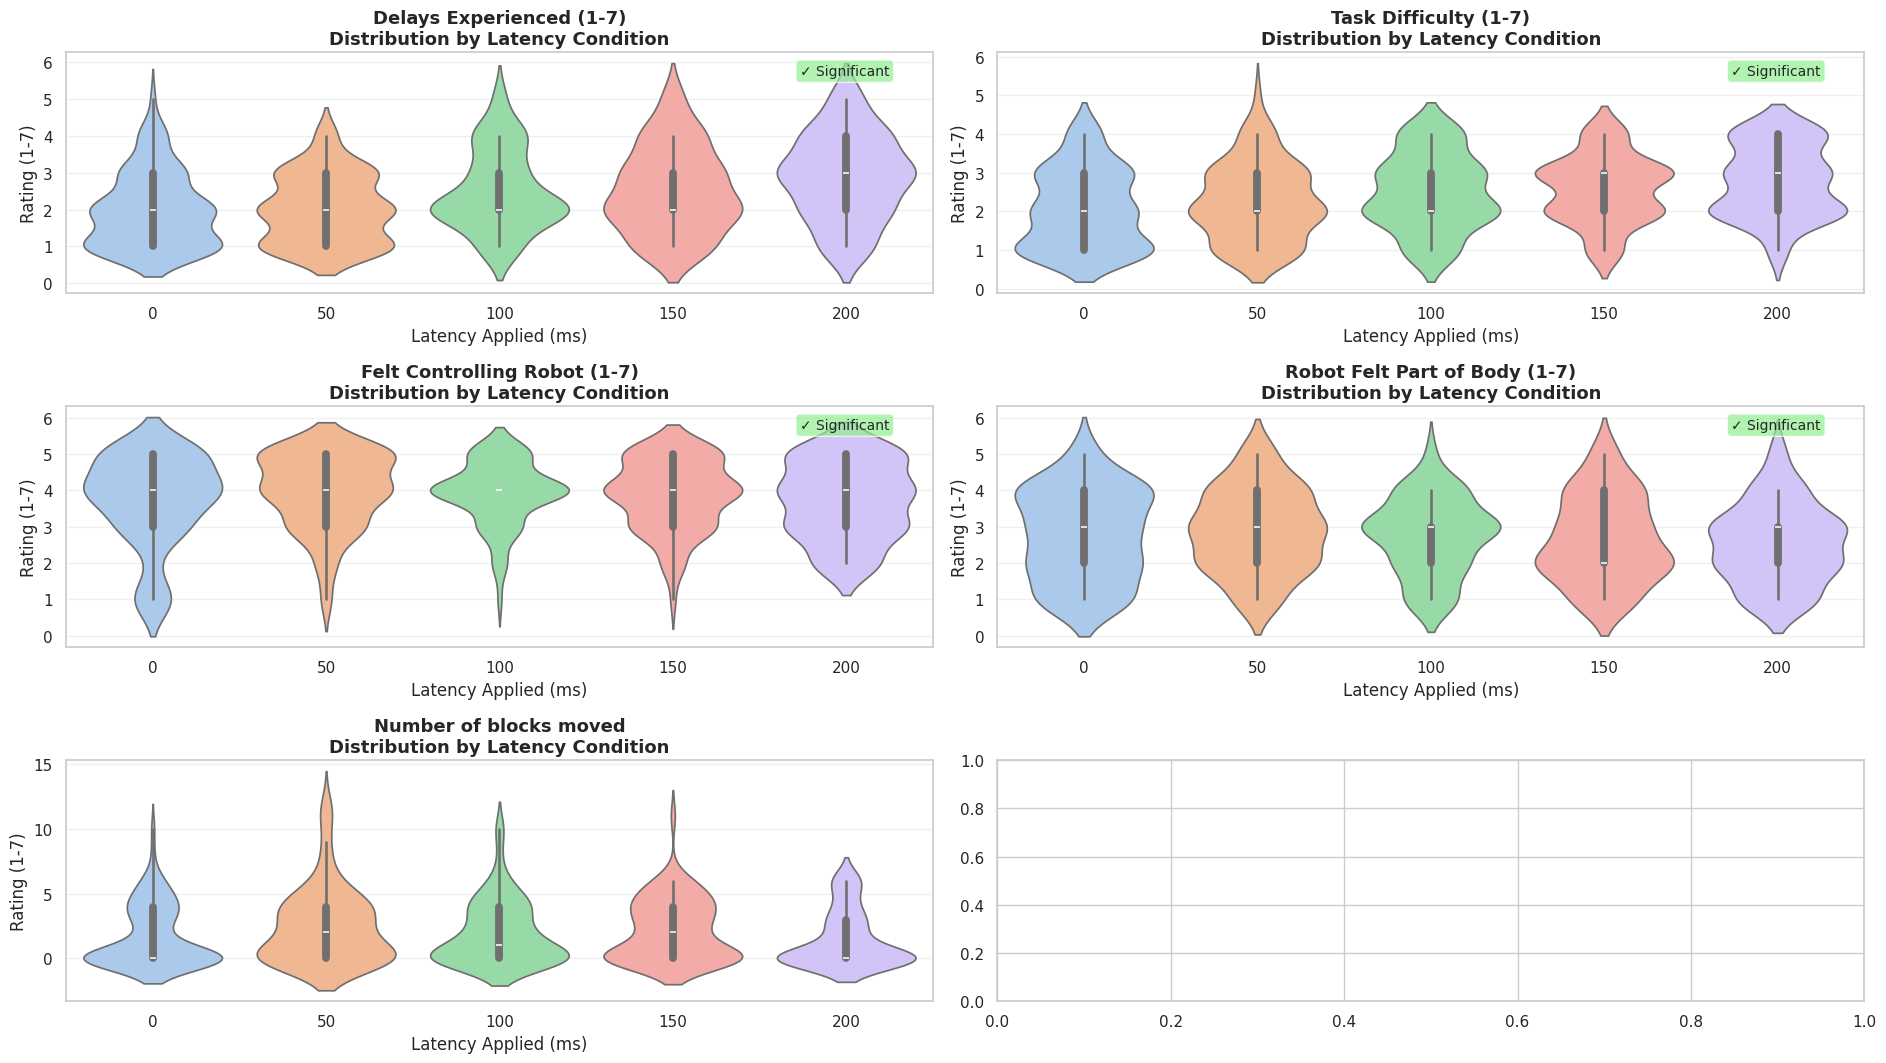

In [232]:
fig, axes = plt.subplots(3, 2, figsize=(19.2, 10.8))  # 16:9 aspect ratio
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(dependent_vars.items()):
    ax = axes[idx]

    # Create violin plot
    sns.violinplot(
        data=df_long,
        x="latency_applied",
        y=dv_name,
        ax=ax,
        palette="pastel",
        inner="box",
    )

    ax.set_xlabel("Latency Applied (ms)", fontsize=12)
    ax.set_ylabel("Rating (1-7)", fontsize=12)
    ax.set_title(
        f"{dv_label}\nDistribution by Latency Condition", fontsize=13, fontweight="bold"
    )

    # Add significance indicator
    if anova_results[dv_name]["significant"]:
        ax.text(
            0.95,
            0.95,
            "✓ Significant",
            transform=ax.transAxes,
            ha="right",
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/anova_violinplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved violin plots to 'plots/anova_violinplots.png'")
plt.show()

In [233]:
summary_data = []
for dv_name, dv_label in dependent_vars.items():
    result = anova_results[dv_name]
    summary_data.append(
        {
            "Dependent Variable": dv_label,
            "SSA": f"{result['SSA']:.4f}",
            "SSE": f"{result['SSE']:.4f}",
            "F-statistic": f"{result['F']:.4f}",
            "p-value": f"{result['p']:.6f}",
            "Significant": "✓ Yes" if result["significant"] else "No",
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Dependent Variable     SSA      SSE F-statistic  p-value Significant
     Delays Experienced (1-7) 19.6988  64.7345     10.9548 0.000000       ✓ Yes
        Task Difficulty (1-7)  7.7709  47.0625      5.9443 0.000187       ✓ Yes
 Felt Controlling Robot (1-7)  2.9258  42.4631      2.4805 0.046539       ✓ Yes
Robot Felt Part of Body (1-7)  6.6502  41.4610      5.7742 0.000244       ✓ Yes
       Number of blocks moved 20.5276 328.5057      2.2496 0.066612          No

✓ Saved scatter plots with regression to 'plots/blocks_vs_selfreports.png'

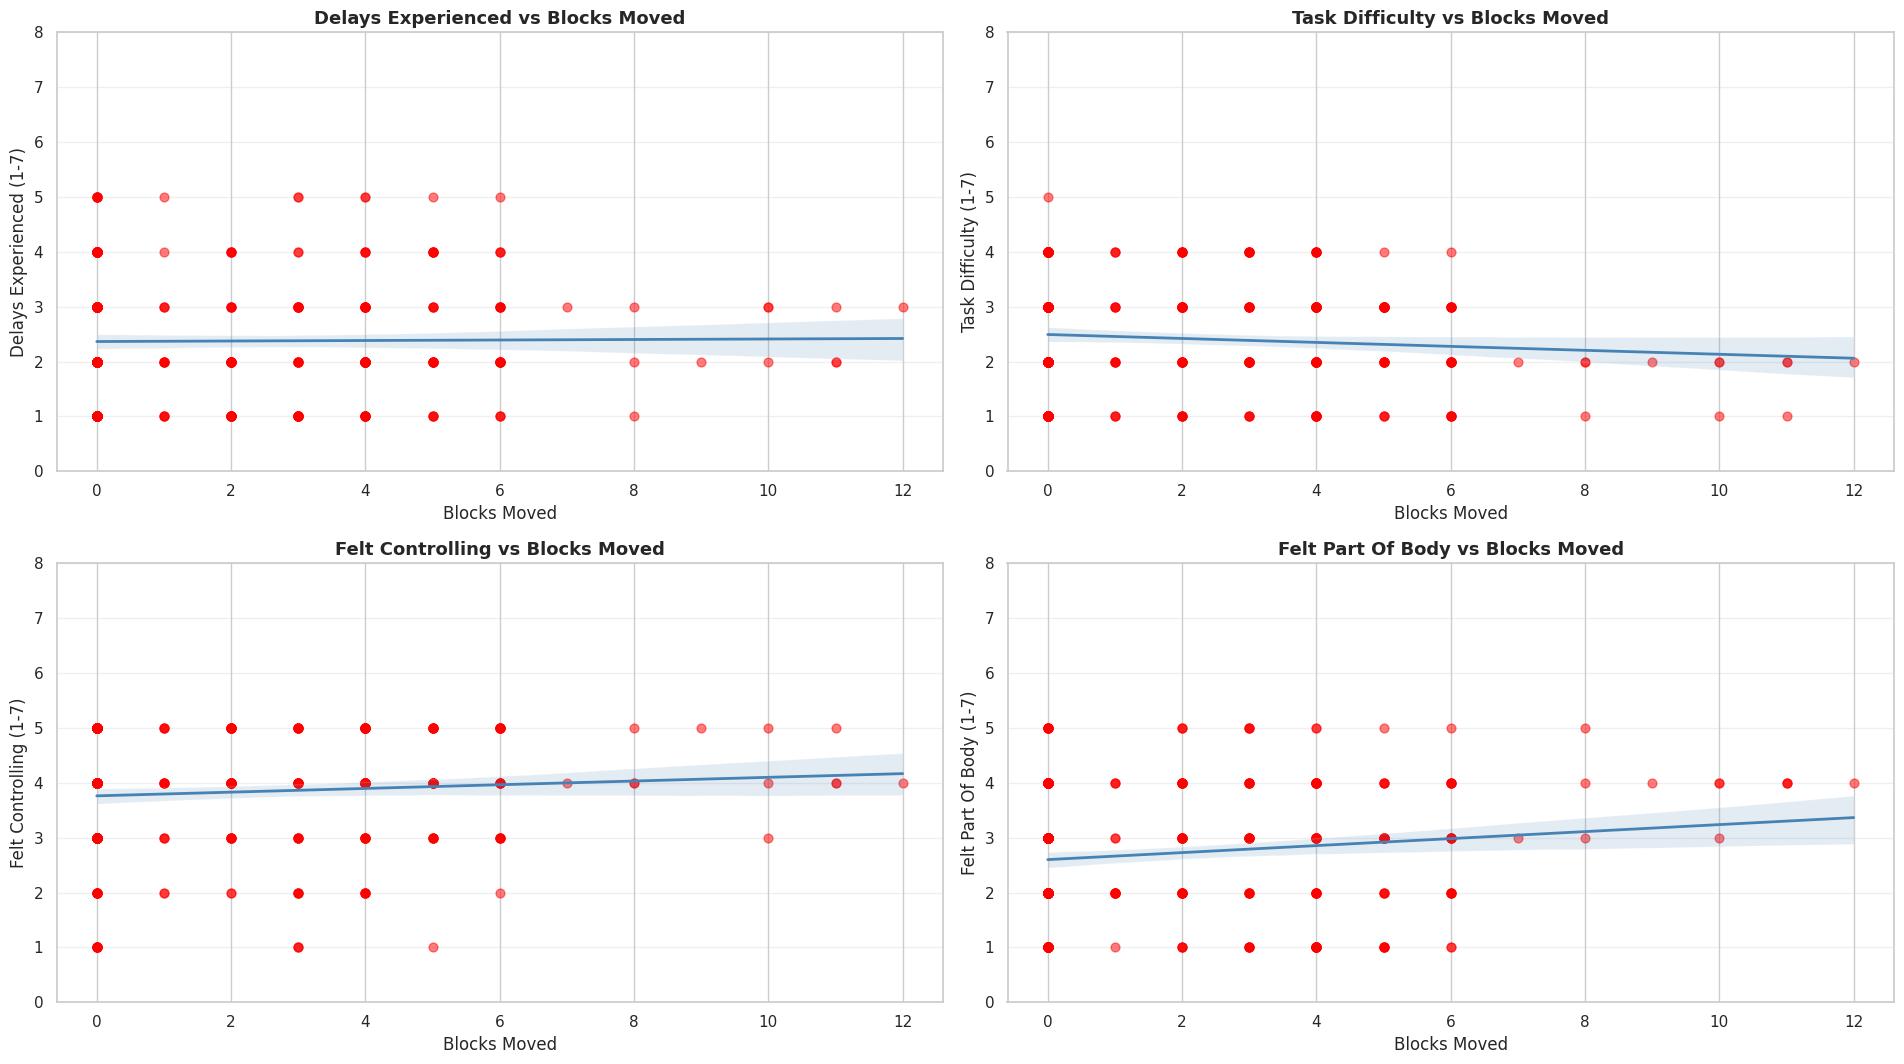

In [234]:
comparison_vars = [
    "delays_experienced",
    "task_difficulty",
    "felt_controlling",
    "felt_part_of_body",
]

fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8))  # 16:9
axes = axes.flatten()

for idx, dv_name in enumerate(comparison_vars):
    ax = axes[idx]

    # Scatter plot with linear regression
    sns.regplot(
        data=df_long,
        x="blocks_moved",
        y=dv_name,
        ax=ax,
        scatter_kws={"color": "red", "alpha": 0.5, "s": 40},
        line_kws={"color": "steelblue", "lw": 2},
    )

    ax.set_xlabel("Blocks Moved", fontsize=12)
    ax.set_ylabel(f"{dv_name.replace('_', ' ').title()} (1-7)", fontsize=12)
    ax.set_title(f"{dv_name.replace('_', ' ').title()} vs Blocks Moved", fontsize=13, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 8)

plt.tight_layout()
plt.savefig("plots/blocks_vs_selfreports.png", dpi=300, bbox_inches="tight")
print("✓ Saved scatter plots with regression to 'plots/blocks_vs_selfreports.png'")
plt.show()

✓ Saved box plots to 'plots/blocks_vs_ratings_boxplots.png'

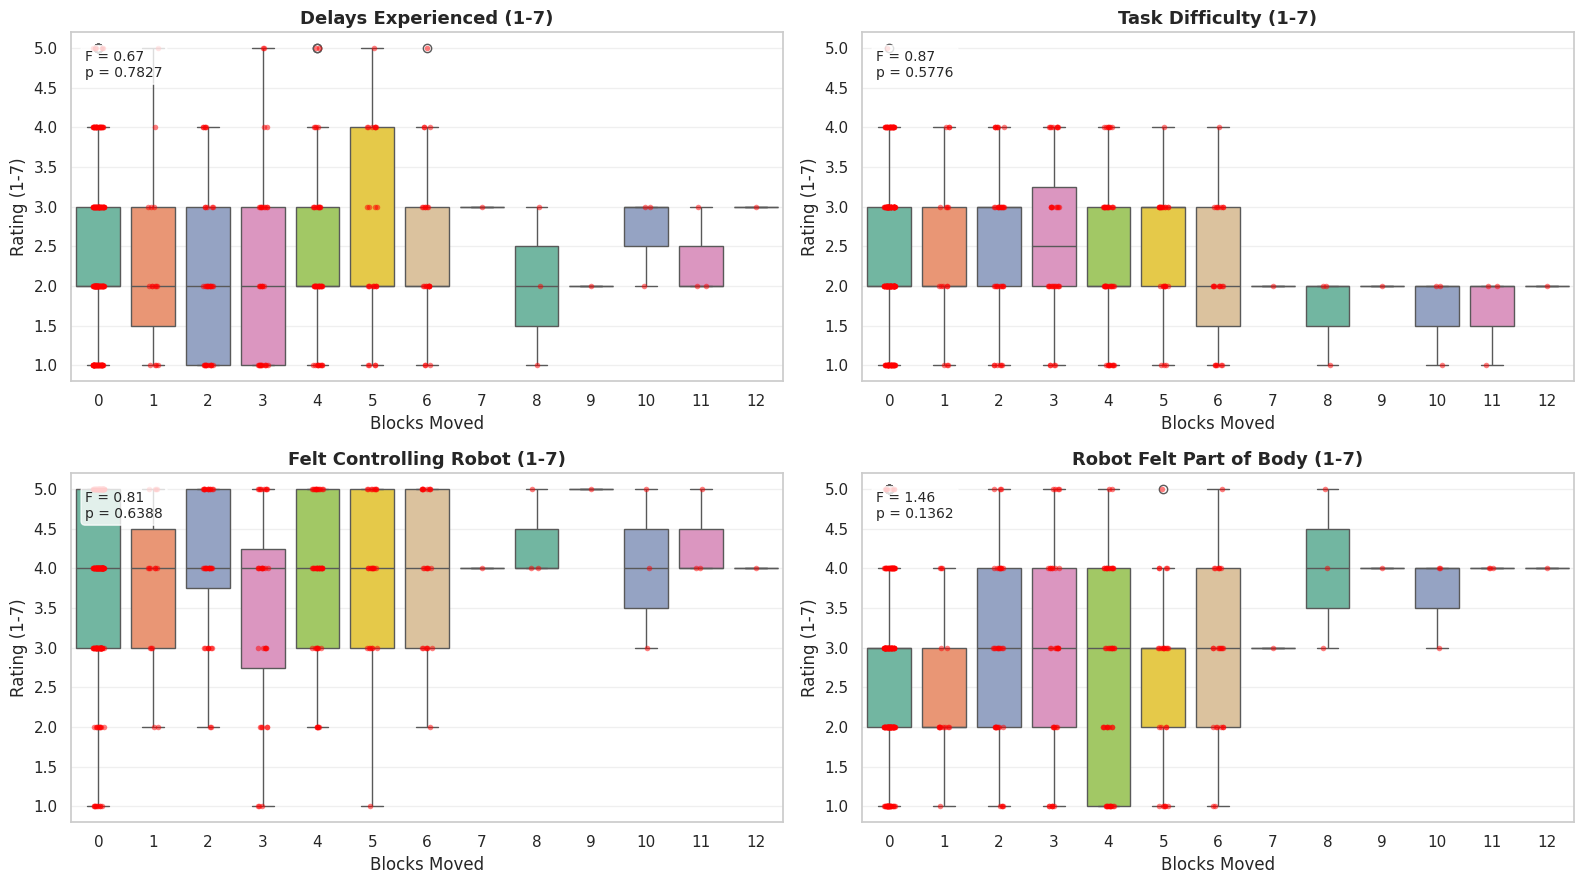

In [235]:
# Define the subjective variables to analyze against blocks_moved
subjective_vars = {
    "delays_experienced": "Delays Experienced (1-7)",
    "task_difficulty": "Task Difficulty (1-7)",
    "felt_controlling": "Felt Controlling Robot (1-7)",
    "felt_part_of_body": "Robot Felt Part of Body (1-7)",
}

# Store stats for consistency across plots
stats_cache = {}

# Calculate One-Way ANOVA for each variable (Grouped by Blocks Moved)
for dv_name in subjective_vars.keys():
    # We treat blocks_moved as categorical groups for the ANOVA
    aov = pg.anova(
        data=df_long, 
        dv=dv_name, 
        between="blocks_moved", 
        detailed=True
    )
    stats_cache[dv_name] = {
        "F": aov.loc[0, "F"],
        "p": aov.loc[0, "p-unc"],
        "significant": aov.loc[0, "p-unc"] < 0.05
    }

# --- 1. BOX PLOTS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(subjective_vars.items()):
    ax = axes[idx]
    stats = stats_cache[dv_name]

    # Create box plot (Set2 palette)
    sns.boxplot(
        data=df_long, 
        x="blocks_moved", 
        y=dv_name, 
        ax=ax, 
        palette="Set2"
    )

    # Add individual points with jitter (Red)
    sns.stripplot(
        data=df_long,
        x="blocks_moved",
        y=dv_name,
        ax=ax,
        color="red",
        alpha=0.5,
        size=4,
    )

    ax.set_xlabel("Blocks Moved", fontsize=12)
    ax.set_ylabel("Rating (1-7)", fontsize=12)
    ax.set_title(f"{dv_label}", fontsize=13, fontweight="bold")

    # Add F and p value text
    stats_text = f"F = {stats['F']:.2f}\np = {stats['p']:.4f}"
    ax.text(
        0.02, 0.95, stats_text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontsize=10
    )

    # Add significance indicator
    if stats["significant"]:
        ax.text(
            0.95, 0.95, "✓ Significant",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/blocks_vs_ratings_boxplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved box plots to 'plots/blocks_vs_ratings_boxplots.png'")
plt.show()

✓ Saved point plots to 'plots/blocks_vs_ratings_pointplots.png'

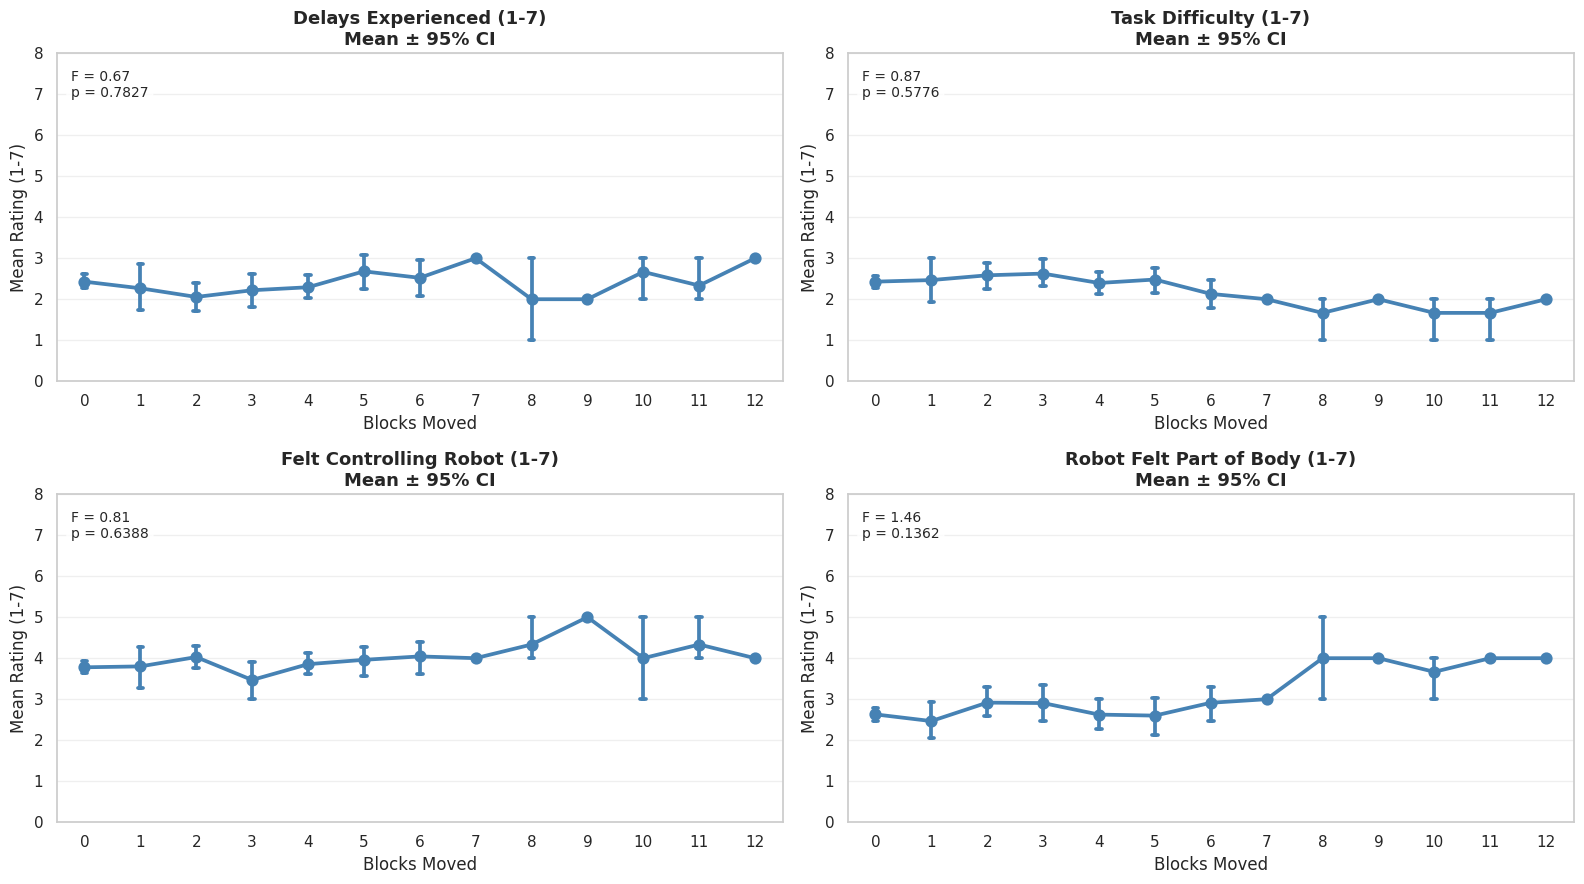

In [236]:
# --- 2. POINT PLOTS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(subjective_vars.items()):
    ax = axes[idx]
    stats = stats_cache[dv_name]

    # Create point plot with 95% CI (Steelblue)
    sns.pointplot(
        data=df_long,
        x="blocks_moved",
        y=dv_name,
        ax=ax,
        errorbar="ci",
        capsize=0.1,
        color="steelblue",
        markers="o",
        linestyles="-",
    )

    ax.set_xlabel("Blocks Moved", fontsize=12)
    ax.set_ylabel("Mean Rating (1-7)", fontsize=12)
    ax.set_title(f"{dv_label}\nMean ± 95% CI", fontsize=13, fontweight="bold")

    # Add F and p value text
    stats_text = f"F = {stats['F']:.2f}\np = {stats['p']:.4f}"
    ax.text(
        0.02, 0.95, stats_text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontsize=10
    )

    # Add significance indicator
    if stats["significant"]:
        ax.text(
            0.95, 0.95, "✓ Significant",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 8)

plt.tight_layout()
plt.savefig("plots/blocks_vs_ratings_pointplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved point plots to 'plots/blocks_vs_ratings_pointplots.png'")
plt.show()

✓ Saved violin plots to 'plots/blocks_vs_ratings_violinplots.png'

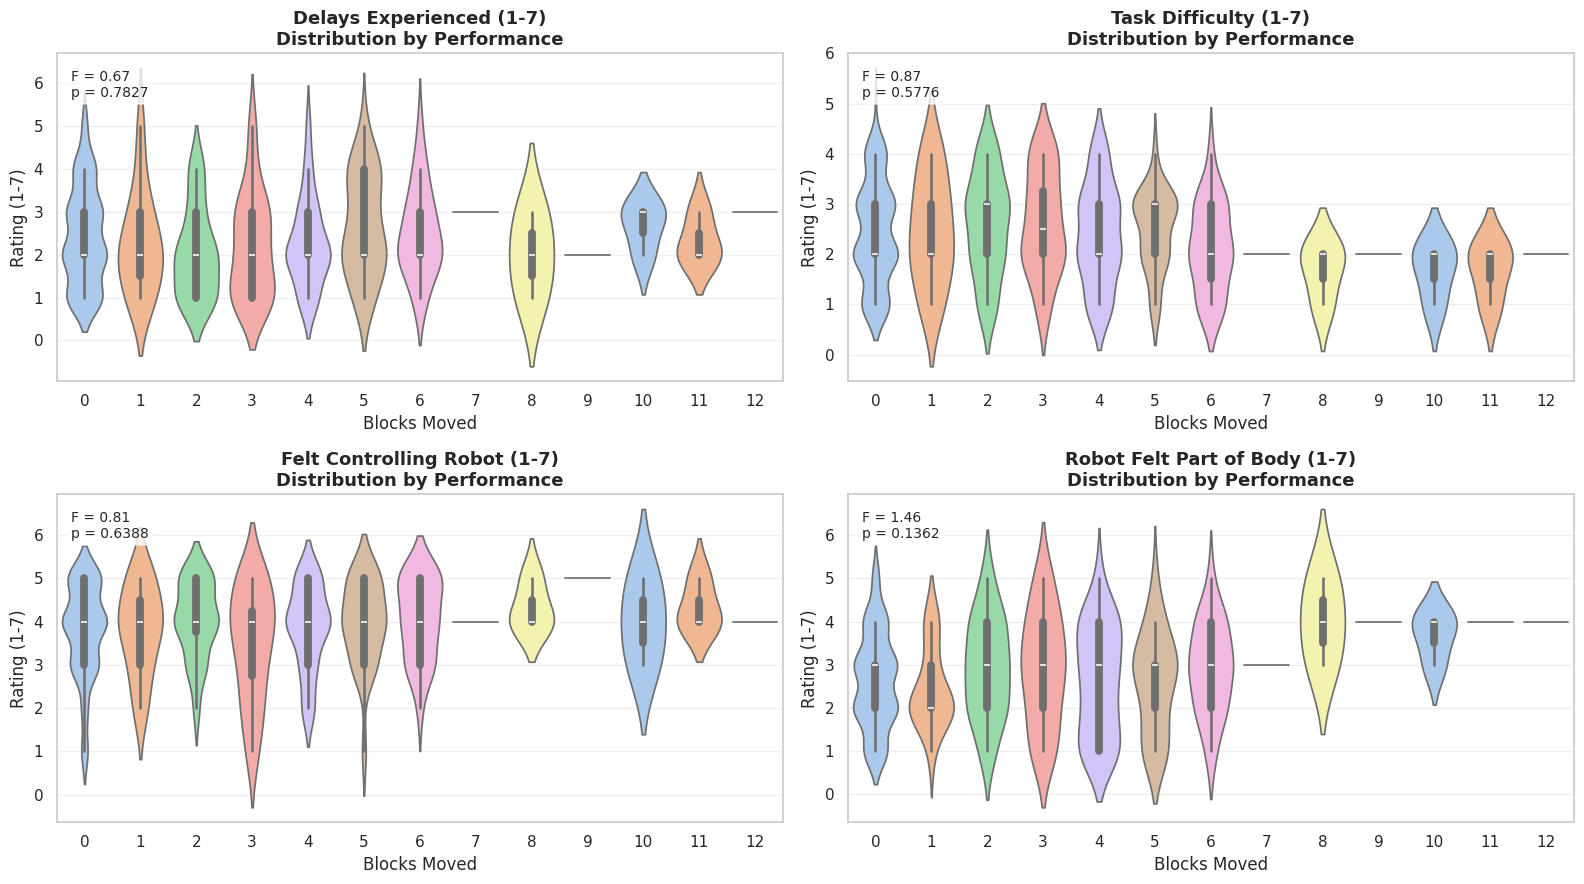

In [237]:
# --- 3. VIOLIN PLOTS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for idx, (dv_name, dv_label) in enumerate(subjective_vars.items()):
    ax = axes[idx]
    stats = stats_cache[dv_name]

    # Create violin plot (Pastel palette)
    sns.violinplot(
        data=df_long,
        x="blocks_moved",
        y=dv_name,
        ax=ax,
        palette="pastel",
        inner="box",
    )

    ax.set_xlabel("Blocks Moved", fontsize=12)
    ax.set_ylabel("Rating (1-7)", fontsize=12)
    ax.set_title(
        f"{dv_label}\nDistribution by Performance", fontsize=13, fontweight="bold"
    )

    # Add F and p value text
    stats_text = f"F = {stats['F']:.2f}\np = {stats['p']:.4f}"
    ax.text(
        0.02, 0.95, stats_text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontsize=10
    )

    # Add significance indicator
    if stats["significant"]:
        ax.text(
            0.95, 0.95, "✓ Significant",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
            fontsize=10,
        )

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/blocks_vs_ratings_violinplots.png", dpi=300, bbox_inches="tight")
print("✓ Saved violin plots to 'plots/blocks_vs_ratings_violinplots.png'")
plt.show()

Correlation between performance (blocks moved) and self-reported ratings:

Variable  r (blocks vs rating)  p-value
     Delays Experienced (1-7)                0.0103   0.8421
        Task Difficulty (1-7)               -0.0908   0.0769
 Felt Controlling Robot (1-7)                0.0799   0.1202
Robot Felt Part of Body (1-7)                0.1379   0.0071

✓ Saved correlation bar plot to 'plots/blocks_vs_ratings_correlations_bar.png'

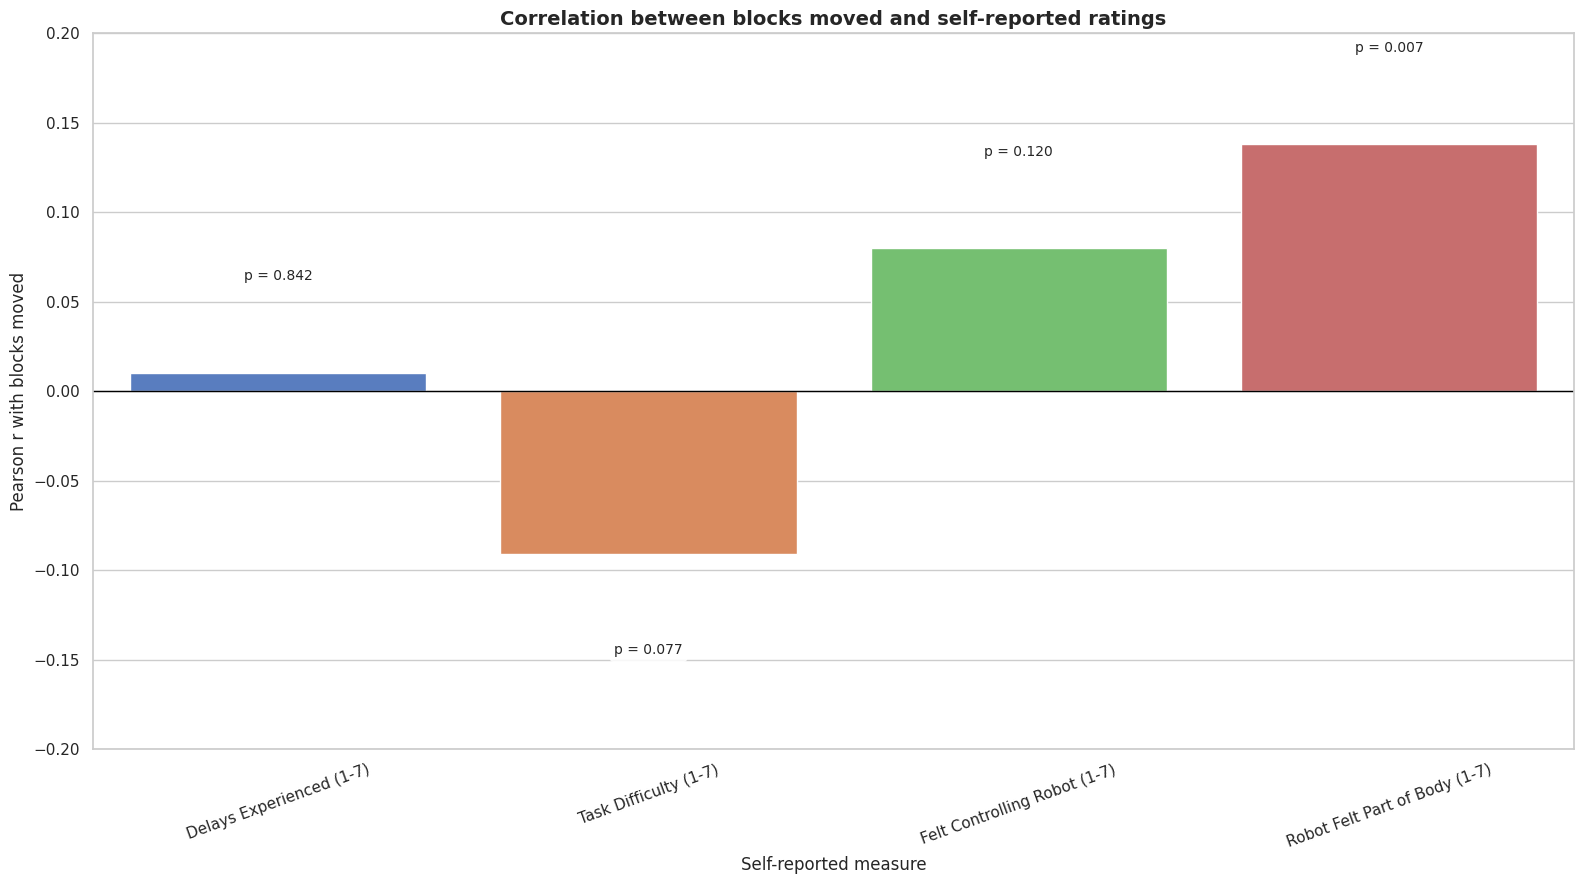

✓ Saved correlation heatmap to 'plots/blocks_vs_ratings_correlations_heatmap.png'

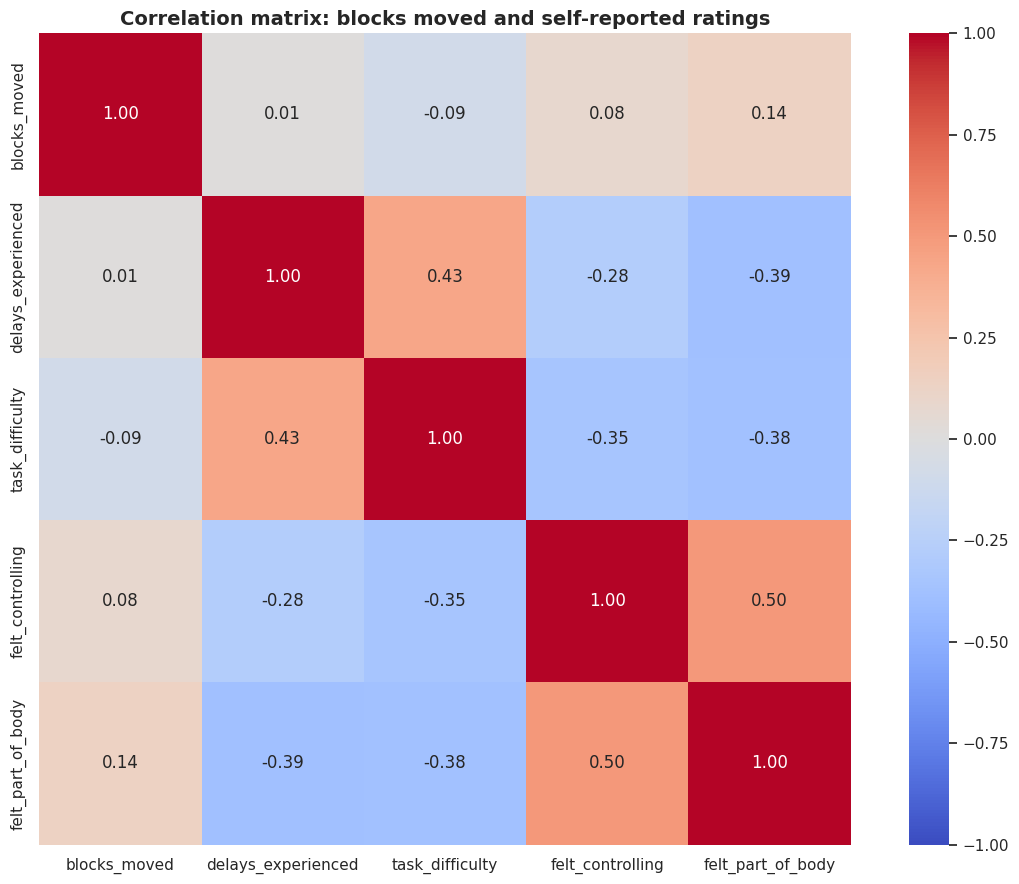

In [238]:
# %%
# Correlation summary: blocks moved vs. self-reported ratings

corr_rows = []
for dv_name, dv_label in subjective_vars.items():
    sub_df = df_long[["blocks_moved", dv_name]].dropna()

    if len(sub_df) < 3:
        r, p = np.nan, np.nan
    else:
        corr_res = pg.corr(sub_df["blocks_moved"], sub_df[dv_name], method="pearson")
        # corr_res may have a non-integer index → always use .iloc
        r = corr_res["r"].iloc[0]
        p = corr_res["p-val"].iloc[0]


    corr_rows.append(
        {
            "Variable": dv_label,
            "r (blocks vs rating)": r,
            "p-value": p,
        }
    )

corr_df = pd.DataFrame(corr_rows)
print("\nCorrelation between performance (blocks moved) and self-reported ratings:")
print(corr_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# %%
# Bar plot of correlations (visual "no correlation" summary)
fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(
    data=corr_df,
    x="Variable",
    y="r (blocks vs rating)",
    ax=ax,
    palette="muted",
)

ax.axhline(0, color="black", linewidth=1)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel("Self-reported measure", fontsize=12)
ax.set_ylabel("Pearson r with blocks moved", fontsize=12)
ax.set_title(
    "Correlation between blocks moved and self-reported ratings",
    fontsize=14,
    fontweight="bold",
)
ax.tick_params(axis="x", rotation=20)

# Annotate bars with p-values
for i, row in corr_df.iterrows():
    r_val = row["r (blocks vs rating)"]
    p_val = row["p-value"]
    ax.text(
        i,
        r_val + (0.05 if r_val >= 0 else -0.05),
        f"p = {p_val:.3f}",
        ha="center",
        va="bottom" if r_val >= 0 else "top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

plt.tight_layout()
plt.savefig("plots/blocks_vs_ratings_correlations_bar.png", dpi=300, bbox_inches="tight")
print("✓ Saved correlation bar plot to 'plots/blocks_vs_ratings_correlations_bar.png'")
plt.show()

# %%
# Correlation heatmap including blocks_moved and all subjective variables
heatmap_cols = ["blocks_moved"] + list(subjective_vars.keys())
corr_matrix_blocks = df_long[heatmap_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    corr_matrix_blocks,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    square=True,
    ax=ax,
)

ax.set_title(
    "Correlation matrix: blocks moved and self-reported ratings",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig("plots/blocks_vs_ratings_correlations_heatmap.png", dpi=300, bbox_inches="tight")
print("✓ Saved correlation heatmap to 'plots/blocks_vs_ratings_correlations_heatmap.png'")
plt.show()
